In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from curlyBrace import curlyBrace
import random
from django.db.models import Avg

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
import math
django.db.connection.close()

In [69]:
qid = 7638

tags = Tag.objects.filter(query_id=qid, seen_docs__gt=0)

import scipy.stats as st

def ci_ac(X, n, a):
    def get_k(a):
        a = (1-(1-a)/2)
        return st.norm.ppf(a)

    k = get_k(a)

    X_tilde = X + k**2/2
    n_tilde = n + k**2
    p_tilde = X_tilde / n_tilde
    q_tilde = 1-p_tilde

    ci = k* np.sqrt(p_tilde*q_tilde/n_tilde) 

    return p_tilde, ci

def plot_alphas(X,n, r_docs, unseen, ax):

    alphas = [x*0.01 for x in range(100)]
    ys = [sum(ci_ac(X,n,x)) for x in alphas]

    unseen = unseen + 100 - n
    rs = [y*unseen for y in ys]
    recalls = [r_docs/(r_docs+r) for r in rs]

    ax.plot(alphas,recalls,color="#bdbdbd"
           )

    thresh = [[0.5,False],[0.6666,False],[0.9,False],[0.95,False]]
    for a,x in zip(alphas,recalls):
        for i, t in enumerate(thresh):
            if a>t[0] and t[1]==False:
                text = f"<{1-t[0]:.0%} that R < {x:.2%}"
                ax.annotate(
                    text,(a,x), xytext=(a-0.1,x-0.1-0.02*i), ha="right",va="top",
                    arrowprops=dict(facecolor='black', 
                        shrink=0.08,width=0.5,headwidth=6,headlength=8
                   )
                )
                t[1] = True

                
    ax.set_title(f"X={X}, n={n}")
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Minimum recall (R)")

tags


<QuerySet [<Tag: random sample 2020-04-15 17:21>, <Tag: random sample 2020-04-07 13:52>, <Tag: predicted relevant sample 2020-02-18 12:50>, <Tag: predicted relevant sample 2020-02-11 17:51>, <Tag: predicted relevant sample 2020-01-29 15:56>, <Tag: predicted relevant sample 2020-01-21 15:38>, <Tag: predicted relevant sample 2019-12-16 16:33>, <Tag: predicted relevant sample 2019-12-04 10:56>, <Tag: db1_maybe>, <Tag: db1_yes_db2_maybe>, <Tag: db1_no_db2_yesmaybe>, <Tag: predicted relevant sample 2019-11-25 19:10>, <Tag: predicted relevant sample 2019-11-13 14:02>, <Tag: predicted relevant sample (comparison) 2019-11-08 10:52>, <Tag: predicted relevant sample 2019-10-23 17:17>, <Tag: unrated by lea>, <Tag: predicted relevant sample (comparison) 2019-10-25 17:07>, <Tag: MaybesDB2>, <Tag: Probably Africa>, <Tag: unrated_with_abstract>, '...(remaining elements truncated)...']>

In [70]:
q = Query.objects.get(pk=qid)
q.doc_set.count()


74955

In [71]:
exclude_tags = Tag.objects.filter(query=qid, title__in=["No abstract","Wrong document type"])

q.doc_set.exclude(tag__in=exclude_tags).count()

51699

In [72]:
db2 = Category.objects.get(pk=363)

In [73]:
db2.doc_set.count()

2032

9718
all
100
0.4
unrated_with_abstract
50
0.4
unassigned_with_abstract
718
0.04317548746518106
Probably Africa
1617
0.10142238713667286
predicted relevant sample 2019-10-23 17:17
992
0.4798387096774194
unrated by lea
568
0.11971830985915492
MaybesDB2
60
0.6
predicted relevant sample (comparison) 2019-10-25 17:07
100
0.52
predicted relevant sample (comparison) 2019-11-08 10:52
1000
0.37
predicted relevant sample 2019-11-13 14:02
1000
0.317
predicted relevant sample 2019-11-25 19:10
1000
0.159
predicted relevant sample 2019-12-04 10:56
999
0.23823823823823823
db1_no_db2_yesmaybe
13
1.0
db1_yes_db2_maybe
199
0.5376884422110553
db1_maybe
135
0.34074074074074073
predicted relevant sample 2019-12-16 16:33
500
0.11
predicted relevant sample 2020-01-21 15:38
297
0.17845117845117844
predicted relevant sample 2020-01-29 15:56
200
0.07
predicted relevant sample 2020-02-11 17:51
100
0.23
predicted relevant sample 2020-02-18 12:50
100
0.08
random sample 2020-04-07 13:52
200
0.025
random sample 2020

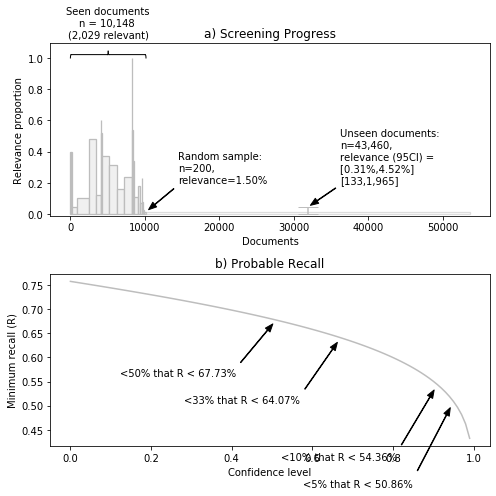

In [74]:
r_in_tags = DocOwnership.objects.filter(relevant__gt=0,tag__in=tags).values_list('doc__pk',flat=True)

exclude_tags = Tag.objects.filter(query=qid, title__in=["No abstract","Wrong document type"])

print(len(set(r_in_tags)))

other_docs = Doc.objects.filter(
    query=qid
).exclude(
    pk__in=set(r_in_tags) | set(Doc.objects.filter(tag__in=exclude_tags).values_list('pk',flat=True)),
)

unseen = other_docs.count()

r_in_tags = DocOwnership.objects.filter(relevant=1, tag__in=tags).values_list('doc__pk',flat=True)
r_docs = Doc.objects.filter(tag__in=tags,category=db2).distinct('id').count()

alpha = 0.95

ab_bottom=0.0
lw = 1.3

n = 0

if "random" in tags.order_by('id').last().title:
    fig, axs = plt.subplots(2, figsize=(7,7))
    ax = axs[0]
else:
    fig, ax = plt.subplots(figsize=(7,4))
     

max_r = 0

for t in tags.order_by('id'):
    print(t)
    print(t.seen_docs)
    tag_relevance = t.docownership_set.filter(doc__category=db2).distinct('pk').count()/t.seen_docs
    print(tag_relevance)
    max_r = max(max_r,tag_relevance)
    ax.bar(
        n, tag_relevance+ab_bottom, bottom=-ab_bottom, width=t.seen_docs, 
        align="edge",color="#f0f0f0", edgecolor="#bdbdbd", linewidth=lw
        
    )
    n+=t.seen_docs
    


str_text = f"Seen documents\nn = {n:,} \n({r_docs:,} relevant)"

curlyBrace(
    fig, ax, (0,max_r), (n,max_r), 0.01, 
    bool_auto=True, str_text=str_text, color="black", lw=1, int_line_num=1
)

w = len(set(other_docs.values_list('pk',flat=True)))

ax.bar(
    n, tag_relevance+ab_bottom, bottom=-ab_bottom, width=w, align="edge",
    color="white", edgecolor="#bdbdbd",alpha=0.5, linewidth=lw
)
ax.set_xlabel("Documents")
ax.set_ylabel("Relevance proportion")

ax.set_ylim(ymin=-0.01,)

if "random" in t.title:
    tag_relevance = tag_relevance = t.docownership_set.filter(doc__category=db2).distinct('pk').count()/t.seen_docs
    ax.annotate(
        f"Random sample:\nn={t.seen_docs},\nrelevance={tag_relevance:.2%}",
        (n,tag_relevance), xytext=(n+w*0.1,0.2),
        arrowprops=dict(facecolor='black', shrink=0.08,width=0.5,headwidth=6,headlength=8)
    )
    r_hat = ci_ac(round(tag_relevance*t.seen_docs),t.seen_docs,0.95)

    print(r_hat)

    ax.errorbar(
        n+w*0.5, r_hat[0], yerr=r_hat[1],capsize=10,
        color="#bdbdbd"
    )

    if r_hat[0]-r_hat[1] < 0:
        lb = 0
    else:
        lb = r_hat[0]-r_hat[1]

    ax.annotate(
        f"Unseen documents:\nn={w:,},\nrelevance (95CI) =\n[{lb:.2%},{sum(r_hat):.2%}]\
        \n[{round(lb*unseen):,.0f},{round(sum(r_hat)*unseen):,.0f}]",
        (n+w*0.5,sum(r_hat)),
        xytext=(n+w*0.6, 0.2),
        arrowprops=dict(facecolor='black', 
                        shrink=0.08,width=0.5,headwidth=6,headlength=8
                       )
    )
    plot_alphas(tag_relevance*t.seen_docs, t.seen_docs, r_docs, unseen, ax = axs[1])

    axs[1].set_title("b) Probable Recall")
    axs[0].set_title("a) Screening Progress")
else:
    curlyBrace(
        fig, ax, (n,tag_relevance+ab_bottom), (n+w,tag_relevance+ab_bottom), 0.01, 
        bool_auto=True, str_text=f"Unseen documents: n={w:,}", color="black", lw=1, int_line_num=1
    )

fig.tight_layout()
    
plt.show()

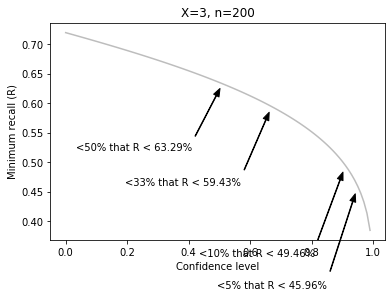

In [75]:
fig, ax = plt.subplots()
plot_alphas(3,200, 2032, 52956, ax = ax)
plt.show()

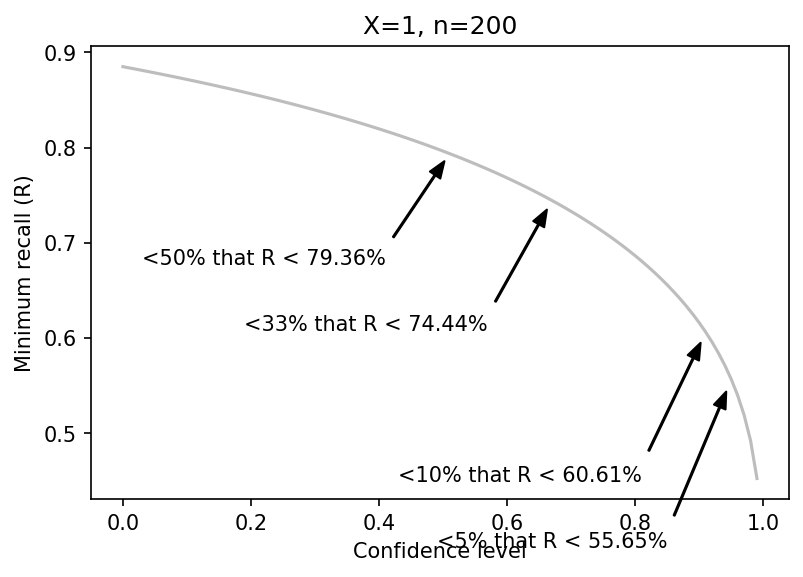

In [76]:
fig, ax = plt.subplots(dpi=150)
plot_alphas(1,200, 2032, 52956, ax = ax)
plt.show()

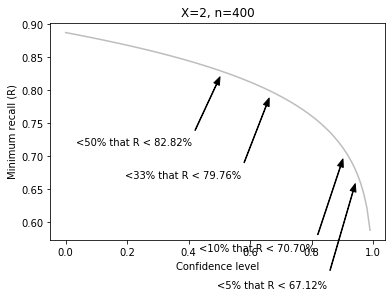

In [77]:
fig, ax = plt.subplots()
plot_alphas(2,400, 2032, 51956, ax = ax)
plt.show()

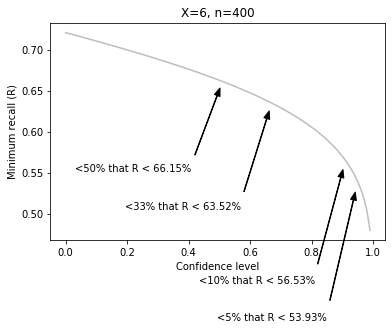

In [78]:
fig, ax = plt.subplots()
plot_alphas(6,400, 2035, 52756, ax = ax)
plt.show()

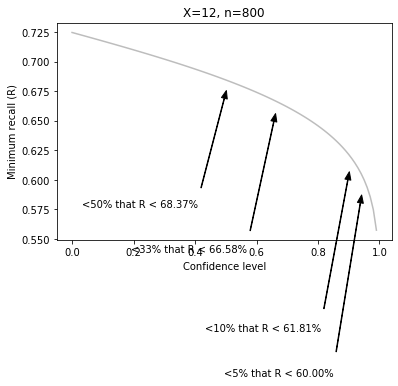

In [79]:
fig, ax = plt.subplots()
plot_alphas(12,800, 2041, 52356, ax = ax)
plt.show()

# Reporting


In [80]:
data = []

training = [4366, 4377, 4378, 4403, 4458]
training_tags = Tag.objects.filter(pk__in=training)
training_dos = DocOwnership.objects.filter(tag__in=training_tags, relevant__gt=0)
training_docs = Doc.objects.filter(pk__in=training_dos.values_list('doc__id',flat=True))
db2_docs = set(DocUserCat.objects.filter(doc__in=training_docs, category=db2).values_list('doc__pk',flat=True))

data.append({
    "Stage": "Training", "i": 0, "ndocs": training_docs.count(), 
    "rdocs": len(set(training_dos.filter(relevant=1).values_list('doc__id', flat=True))),
    "db2docs": training_db2.count()
})

predicted_tags = [4445, 4472, 4562, 4586, 4602, 4612, 4661, 4709, 4715, 4752, 4762]

for i,t in enumerate(Tag.objects.filter(pk__in=predicted_tags).order_by('id')):
    dos = t.docownership_set.filter(relevant__gt=0)
    docs =  Doc.objects.filter(pk__in=dos.values_list('doc__id',flat=True))
    db2_docs = set(DocUserCat.objects.filter(doc__in=docs, category=db2).values_list('doc__pk',flat=True))
    data.append({
        "Stage": "Predicted", "i": i+1, "ndocs": docs.count(), 
        "rdocs": len(set(dos.filter(relevant=1).values_list('doc__id', flat=True))),
        "db2docs": len(db2_docs)
    })
    
i+=1
    
random_tags = [5293, 5365]
dos = DocOwnership.objects.filter(tag__in=random_tags, relevant__gt=0)
docs =  Doc.objects.filter(pk__in=dos.values_list('doc__id',flat=True))
db2_docs = set(DocUserCat.objects.filter(doc__in=docs, category=db2).values_list('doc__pk',flat=True))
data.append({
    "Stage": "Random", "i": i+1, "ndocs": docs.count(), 
    "rdocs": len(set(dos.filter(relevant=1).values_list('doc__id', flat=True))),
    "db2docs": len(db2_docs)
})


df = pd.DataFrame.from_dict(data)
df['db2_relevance'] = df["db2docs"] / df['ndocs']
df.tail()

,Stage,i,ndocs,rdocs,db2docs,db2_relevance
8,Predicted,8,295,89,53,0.179661
9,Predicted,9,200,30,14,0.070000
10,Predicted,10,100,37,23,0.230000
11,Predicted,11,100,19,8,0.080000
12,Random,12,399,22,8,0.020050


In [81]:
dos = DocOwnership.objects.filter(tag__in=training+predicted_tags+random_tags, relevant__gt=0)
dos.count()

10251

,doc__id,db2
0,49638,0.0
1,64887,0.0
2,77756,0.0
3,88908,0.0
4,96092,0.0
...,...,...
10321,2457803,0.0
10322,2461600,0.0
10323,2464779,0.0
10324,2477347,0.0


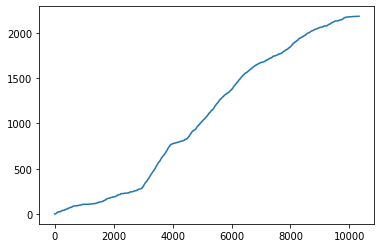

In [92]:
docorder = pd.DataFrame.from_dict(dos.filter(finish__isnull=False).order_by('tag__id','finish').values('doc__id'))
db2_inclusion = pd.DataFrame.from_dict(DocUserCat.objects.filter(category=db2).values('doc__id'))
db2_inclusion['db2'] = 1
docorder = docorder.merge(db2_inclusion, how="left")
docorder = docorder.fillna(0)

plt.plot(docorder['db2'].cumsum())

docorder

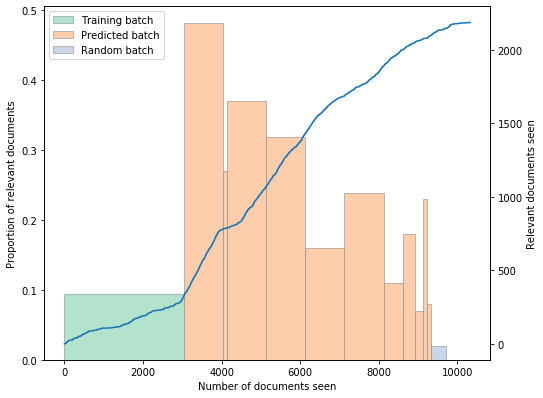

In [97]:
cmap = {
    "Training": "#b3e2cd",
    "Predicted": "#fdcdac",
    "Random": "#cbd5e8",
}

fig, ax = plt.subplots(figsize=(8,6.5))
left=0
labels = []
for i, row in df.iterrows():
    if row['Stage'] + " batch" not in labels:
        label = row['Stage'] + " batch"
        labels.append(label)
    else:
        label = None
    ax.bar(
        left, row['db2_relevance'], width=row['ndocs'], align="edge",
        color=cmap[row['Stage']],
        lw=0.5,
        ec="grey",
        label=label
    )
    left+=row['ndocs']
    

ax.set_xlabel('Number of documents seen')
ax.set_ylabel('Proportion of relevant documents')

ax2 = ax.twinx()
ax2.plot(docorder['db2'].cumsum())
ax2.set_ylabel("Relevant documents seen")

ax.legend(loc="upper left")

plt.show()

9738
all
100
0.22
unrated_with_abstract
50
0.2
unassigned_with_abstract
718
0.13509749303621169
Probably Africa
1617
0.20531849103277675
predicted relevant sample 2019-10-23 17:17
992
0.6713709677419355
unrated by lea
568
0.20598591549295775
MaybesDB2
60
0.7666666666666667
predicted relevant sample (comparison) 2019-10-25 17:07
100
0.6
predicted relevant sample (comparison) 2019-11-08 10:52
1000
0.567
predicted relevant sample 2019-11-13 14:02
1000
0.519
predicted relevant sample 2019-11-25 19:10
1000
0.265
predicted relevant sample 2019-12-04 10:56
999
0.38038038038038036
db1_no_db2_yesmaybe
13
0.46153846153846156
db1_yes_db2_maybe
199
0.6834170854271356
db1_maybe
135
0.6444444444444445
predicted relevant sample 2019-12-16 16:33
500
0.234
predicted relevant sample 2020-01-21 15:38
297
0.30303030303030304
predicted relevant sample 2020-01-29 15:56
200
0.15
predicted relevant sample 2020-02-11 17:51
100
0.37
predicted relevant sample 2020-02-18 12:50
100
0.19
random sample 2020-04-07 13

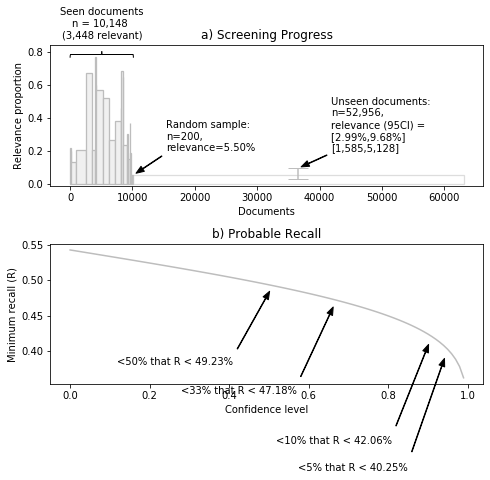

In [93]:
r_in_tags = DocOwnership.objects.filter(relevant__gt=0,tag__in=tags).values_list('doc__pk',flat=True)

exclude_tag = Tag.objects.get(query=qid, title="No abstract")

print(len(set(r_in_tags)))

other_docs = Doc.objects.filter(
    query=qid
).exclude(
    pk__in=set(r_in_tags) | set(Doc.objects.filter(tag=exclude_tag).values_list('pk',flat=True)),
)

unseen = other_docs.count()

r_in_tags = DocOwnership.objects.filter(relevant=1, tag__in=tags).values_list('doc__pk',flat=True)
r_docs = Doc.objects.filter(pk__in=r_in_tags).count()

alpha = 0.95

ab_bottom=0.0
lw = 1.3

n = 0

if "random" in tags.order_by('id').last().title:
    fig, axs = plt.subplots(2, figsize=(7,7))
    ax = axs[0]
else:
    fig, ax = plt.subplots(figsize=(7,4))
     

max_r = 0

for t in tags.order_by('id'):
    print(t)
    print(t.seen_docs)
    print(t.relevance)
    max_r = max(max_r,t.relevance)
    ax.bar(
        n, t.relevance+ab_bottom, bottom=-ab_bottom, width=t.seen_docs, 
        align="edge",color="#f0f0f0", edgecolor="#bdbdbd", linewidth=lw
        
    )
    n+=t.seen_docs
    


str_text = f"Seen documents\nn = {n:,} \n({r_docs:,} relevant)"

curlyBrace(
    fig, ax, (0,max_r), (n,max_r), 0.01, 
    bool_auto=True, str_text=str_text, color="black", lw=1, int_line_num=1
)

w = len(set(other_docs.values_list('pk',flat=True)))

ax.bar(
    n, t.relevance+ab_bottom, bottom=-ab_bottom, width=w, align="edge",
    color="white", edgecolor="#bdbdbd",alpha=0.5, linewidth=lw
)
ax.set_xlabel("Documents")
ax.set_ylabel("Relevance proportion")

ax.set_ylim(ymin=-0.01,)

if "random" in t.title:
    ax.annotate(
        f"Random sample:\nn={t.seen_docs},\nrelevance={t.relevance:.2%}",
        (n,t.relevance), xytext=(n+w*0.1,0.2),
        arrowprops=dict(facecolor='black', shrink=0.08,width=0.5,headwidth=6,headlength=8)
    )
    r_hat = ci_ac(round(t.relevance*t.seen_docs),t.seen_docs,0.95)

    print(r_hat)

    ax.errorbar(
        n+w*0.5, r_hat[0], yerr=r_hat[1],capsize=10,
        color="#bdbdbd"
    )

    if r_hat[0]-r_hat[1] < 0:
        lb = 0
    else:
        lb = r_hat[0]-r_hat[1]

    ax.annotate(
        f"Unseen documents:\nn={w:,},\nrelevance (95CI) =\n[{lb:.2%},{sum(r_hat):.2%}]\
        \n[{round(lb*unseen):,.0f},{round(sum(r_hat)*unseen):,.0f}]",
        (n+w*0.5,sum(r_hat)),
        xytext=(n+w*0.6, 0.2),
        arrowprops=dict(facecolor='black', 
                        shrink=0.08,width=0.5,headwidth=6,headlength=8
                       )
    )
    plot_alphas(t.rel_docs, t.seen_docs, r_docs, unseen, ax = axs[1])

    axs[1].set_title("b) Probable Recall")
    axs[0].set_title("a) Screening Progress")
else:
    curlyBrace(
        fig, ax, (n,t.relevance+ab_bottom), (n+w,t.relevance+ab_bottom), 0.01, 
        bool_auto=True, str_text=f"Unseen documents: n={w:,}", color="black", lw=1, int_line_num=1
    )

fig.tight_layout()
    
plt.show()

In [81]:
53151*0.0299

1589.2149

In [58]:
udict = {}
users = DocOwnership.objects.filter(
    tag__in=tags
).distinct('user__username').values_list('user__username',flat=True)
colours = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
for i,u in enumerate(users):
    udict[u] = colours[i]
udict

{'apfisch@umich.edu': '#8dd3c7',
 'ee18ivc@leeds.ac.uk': '#ffffb3',
 'gsotnik@umich.edu': '#bebada',
 'l.berrangford@leeds.ac.uk': '#fb8072',
 'miriam@iri.columbia.edu': '#80b1d3'}

In [59]:
for name, c in udict.items():
    print(name, c)

apfisch@umich.edu #8dd3c7
ee18ivc@leeds.ac.uk #ffffb3
gsotnik@umich.edu #bebada
l.berrangford@leeds.ac.uk #fb8072
miriam@iri.columbia.edu #80b1d3


all
unrated_with_abstract
unassigned_with_abstract
Probably Africa
predicted relevant sample 2019-10-23 17:17
unrated by lea
MaybesDB2
predicted relevant sample (comparison) 2019-10-25 17:07
predicted relevant sample (comparison) 2019-11-08 10:52
predicted relevant sample 2019-11-13 14:02
predicted relevant sample 2019-11-25 19:10
predicted relevant sample 2019-12-04 10:56
db1_no_db2_yesmaybe
db1_yes_db2_maybe
db1_maybe
predicted relevant sample 2019-12-16 16:33
predicted relevant sample 2020-01-21 15:38
predicted relevant sample 2020-01-29 15:56
predicted relevant sample 2020-02-11 17:51
predicted relevant sample 2020-02-18 12:50
random sample 2020-04-07 13:52


[Text(0, 0, 'all'),
 Text(0, 0, 'unrated_with_abstract'),
 Text(0, 0, 'unassigned_with_abstract'),
 Text(0, 0, 'Probably Africa'),
 Text(0, 0, 'predicted relevant sample 2019-10-23 17:17'),
 Text(0, 0, 'unrated by lea'),
 Text(0, 0, 'MaybesDB2'),
 Text(0, 0, 'predicted relevant sample (comparison) 2019-10-25 17:07'),
 Text(0, 0, 'predicted relevant sample (comparison) 2019-11-08 10:52'),
 Text(0, 0, 'predicted relevant sample 2019-11-13 14:02'),
 Text(0, 0, 'predicted relevant sample 2019-11-25 19:10'),
 Text(0, 0, 'predicted relevant sample 2019-12-04 10:56'),
 Text(0, 0, 'db1_no_db2_yesmaybe'),
 Text(0, 0, 'db1_yes_db2_maybe'),
 Text(0, 0, 'db1_maybe'),
 Text(0, 0, 'predicted relevant sample 2019-12-16 16:33'),
 Text(0, 0, 'predicted relevant sample 2020-01-21 15:38'),
 Text(0, 0, 'predicted relevant sample 2020-01-29 15:56'),
 Text(0, 0, 'predicted relevant sample 2020-02-11 17:51'),
 Text(0, 0, 'predicted relevant sample 2020-02-18 12:50'),
 Text(0, 0, 'random sample 2020-04-07 13:

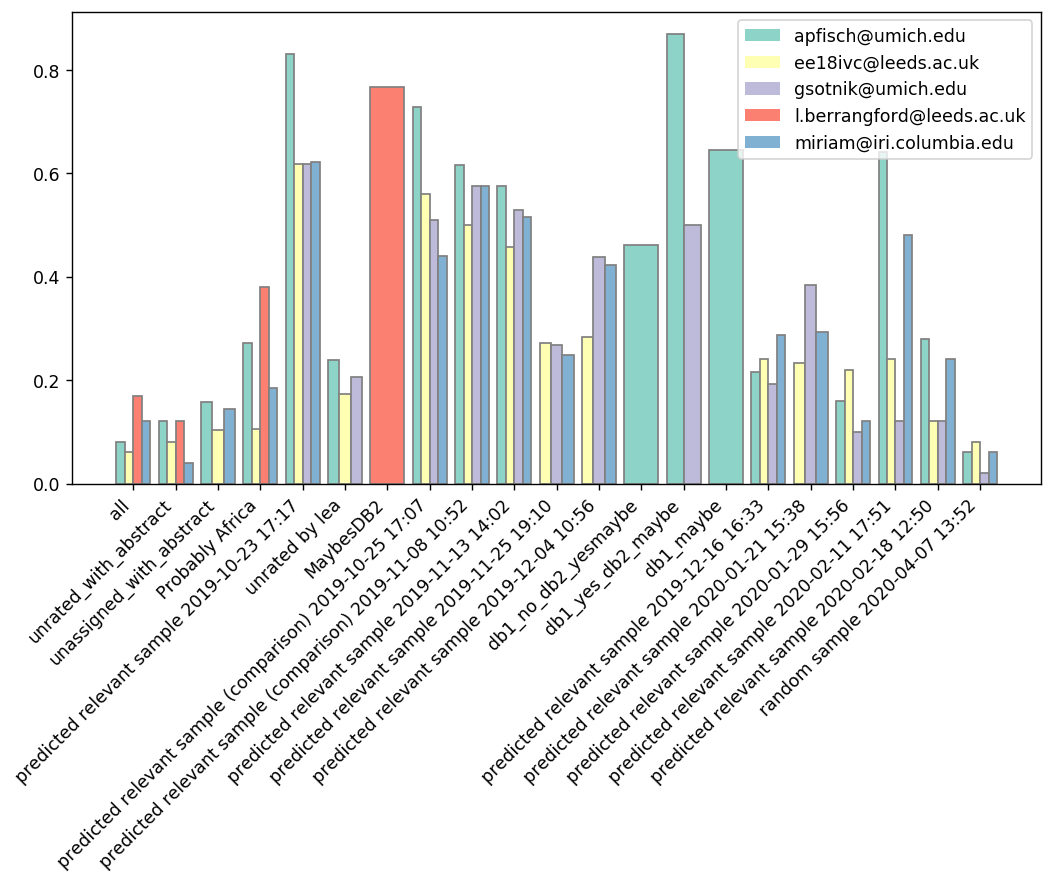

In [60]:
fig, ax = plt.subplots(dpi=125, figsize=(10,5))
xticks = []
xticklabels = []
for i, t in enumerate(tags.filter(seen_docs__gt=0).order_by('id')):
    xticks.append(i)
    xticklabels.append(t.title)
    dodf = pd.DataFrame.from_dict(DocOwnership.objects.filter(tag=t).values('user__username','relevant'))
    print(t)
    nu = len(dodf.user__username.unique())
    for j, (name, group) in enumerate(dodf.groupby('user__username')):
        r = group[group['relevant']==1].shape[0]/group.shape[0]
        ax.bar(
            i-0.4+0.4/nu+j*0.8/nu,r, width=0.8/nu,
            color=udict[name],
            edgecolor="grey"
        )
        
for name, c in udict.items():
    ax.bar(0,0,color=c, label=name)
        
ax.legend()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45,ha="right")

In [61]:
r_in_tags = DocOwnership.objects.filter(relevant=1, tag__in=tags).values_list('doc__pk',flat=True)
r_docs = Doc.objects.filter(pk__in=r_in_tags)
nr_docs = r_docs.count()
print("relevant docs", nr_docs)
#print(r_docs.filter(category__name__in=["Maybe","Yes"]).count())

relevant docs 3437


$maxrel = \frac{relevant}{target} - relevant$

In [62]:
target_recall = 0.9
relevant_remaining = math.ceil(nr_docs/target_recall)-nr_docs
print(relevant_remaining)
relevant_remaining/w

382


0.00718707079829166

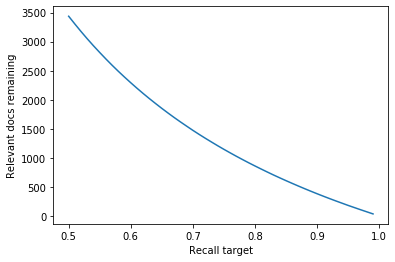

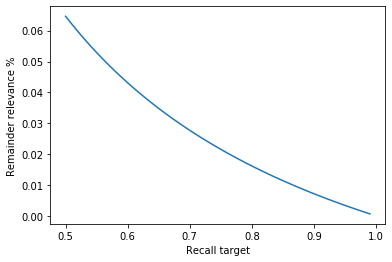

In [63]:
targets = [x*0.01 for x in range(50,100)]
remainders = [math.ceil(nr_docs/t)-nr_docs for t in targets]

plt.plot(targets,remainders)
plt.xlabel("Recall target")
plt.ylabel("Relevant docs remaining")

plt.show()


remainder_pcnt = [rr/w for rr in remainders]

plt.plot(targets,remainder_pcnt)
plt.xlabel("Recall target")
plt.ylabel("Remainder relevance %")
plt.show()

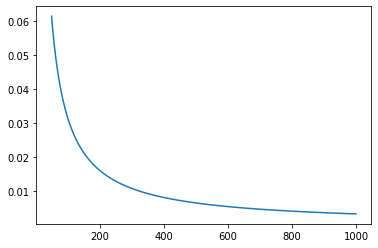

In [64]:
N = list(range(50,1000))
X = [0]*len(N)

cis = []

for n in N:
    cis.append(sum(ci_ac(0,n,.9)))

plt.plot(N,cis)


In [65]:
sum(ci_ac(4,915,.9))

0.00996746721890213

In [66]:
sum(ci_ac(0,n,.9))

0.003259029201808823

There is a < 50% chance that r > 1.24%
There is a < 33% chance that r > 1.36%
There is a < 10% chance that r > 1.71%
There is a < 5% chance that r > 1.86%


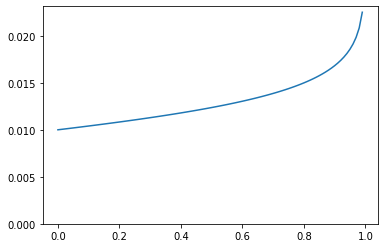

There is a < 50% chance that recall < 83.88%
There is a < 33% chance that recall < 82.63%
There is a < 10% chance that recall < 79.10%
There is a < 5% chance that recall < 77.68%


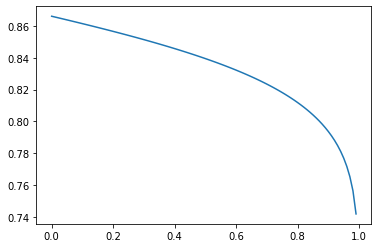

In [67]:
alphas = [x*0.01 for x in range(100)]
ys = [sum(ci_ac(10,1000,x)) for x in alphas]

thresh = [[0.5,False],[0.6666,False],[0.9,False],[0.95,False]]
for a,x in zip(alphas,ys):
    for t in thresh:

        if a>t[0] and t[1]==False:
            print(f"There is a < {1-t[0]:.0%} chance that r > {x:.2%}")
            t[1] = True
    
plt.plot(alphas,ys)
plt.ylim(ymin=0)

plt.show()

unseen = other_docs.count()
all_relevant = DocOwnership.objects.filter(relevant=1,)
rs = [y*unseen for y in ys]
recalls = [nr_docs/(nr_docs+r) for r in rs]

plt.plot(alphas,recalls)

thresh = [[0.5,False],[0.6666,False],[0.9,False],[0.95,False]]
for a,x in zip(alphas,recalls):
    for t in thresh:
        if a>t[0] and t[1]==False:
            print(f"There is a < {1-t[0]:.0%} chance that recall < {x:.2%}")
            t[1] = True


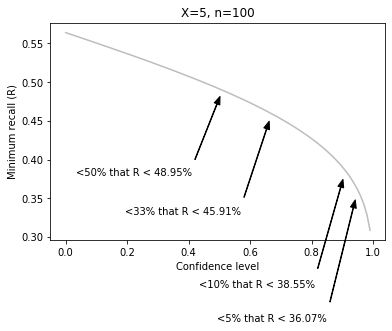

In [68]:
   
fig, ax = plt.subplots()
plot_alphas(5,100, nr_docs, unseen, ax = ax)
plt.show()

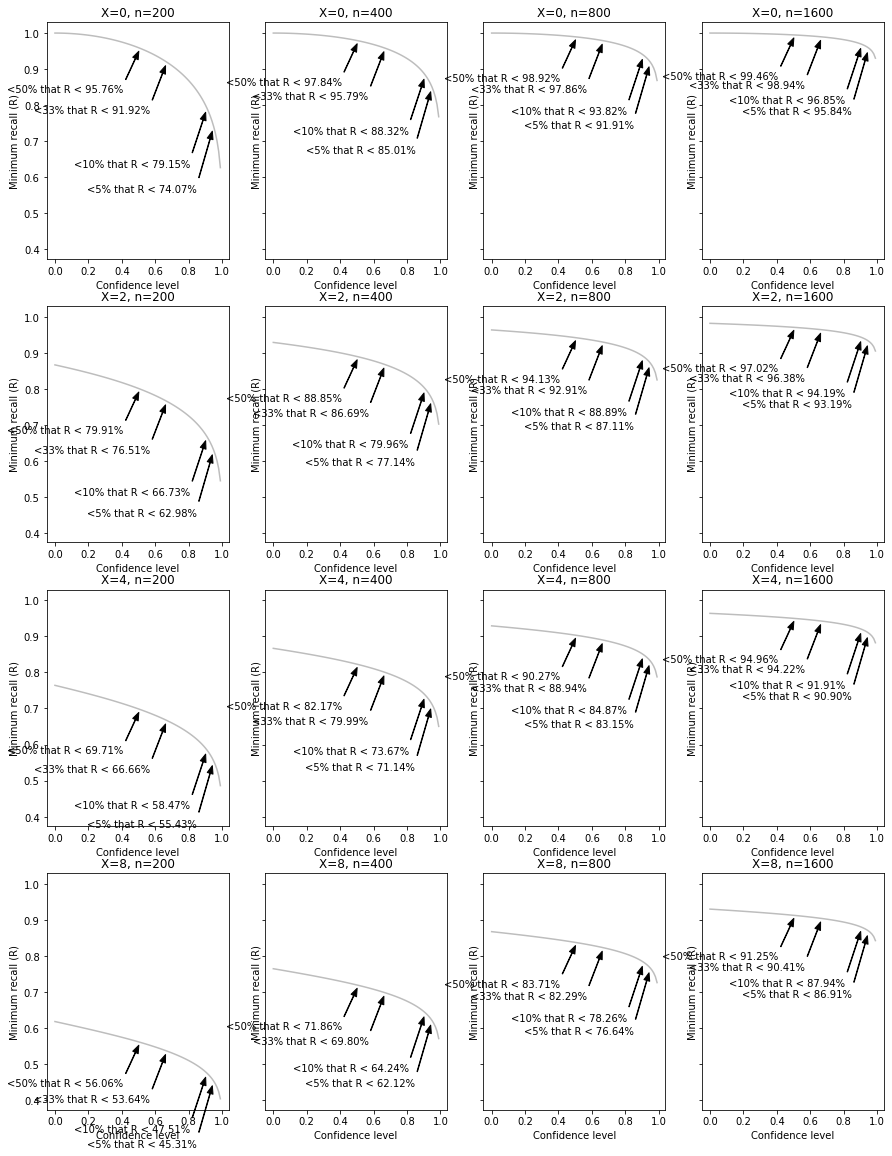

In [69]:
fig, axs = plt.subplots(4,4,sharey=True, figsize=(15,20))
for j,X in enumerate([0,2,4,8]):
    for i,n in enumerate([200,400,800,1600]):
        ax = axs[j,i]
        if n==100 and X>0:
            continue
        plot_alphas(X,n, nr_docs, unseen, ax = ax)

In [ ]:
fig, axs = plt.subplots(4,4,sharey=True, figsize=(15,20))
for j,X in enumerate([0,2,4,8]):
    for i,n in enumerate([200,400,800,1600]):
        ax = axs[j,i]
        if n==100 and X>0:
            continue
        plot_alphas(X,n, nr_docs+20, unseen, ax = ax)

In [85]:
other_docs.count()


53156

In [86]:
newtag = True
if newtag:
    s = random.sample(set(other_docs.values_list('pk',flat=True)),200)
    import datetime
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    q = Query.objects.get(pk=7638)
    t1 = Tag(
        title="random sample {}".format(now),
        query=q
    )
    t1.save()

    for did in s:
        d = Doc.objects.get(pk=did)
        d.tag.add(t1)


    t1.update_tag()